## Hello

Welcome to Danyel Koca's code submission for ZS ADS Track Transfer Hackathon 2021.

Below, firstly, I merge, process and conduct EDA on data.
Then, 3 models are tried for solving this problem: 1) Logistic Regression, 2) Boosted Decision Trees (XGBoost) 3) Deep learning (Multilayer perceptron - implemented in PyTorch)

XGBoost iteration has been submitted as it has achieved the highest accuracy (0.5*industry_f1_score + 0.3 + type_f1_score + 0.2 * product_f1_score)

Test score: 0.8939783575828679

This script saves several outputs files such as processed databases, index-value mapping file and finally predictions on test data.

## 0. Load Modules

In [86]:
# Main
import os
import pandas as pd
import numpy as np
from pathlib import Path
import json
import random

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
import xgboost
import torch
import torch.nn as nn
import torch.optim as optim

# Validation
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Others
import locale
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## 1. Merge Data

In [87]:
# Read & Merge TRAIN files

csv_directory = "4a4a221c-e-dataset/dataset/train"
train_txt_directory = "4a4a221c-e-dataset/dataset/train/product_info"

# Loop  through training CSVs and merge them into a database (db_train)
initial = True
print("Merging train files")

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        industry = filename.split("_")[0]
        if initial:
            db_train = pd.read_csv(os.path.join(csv_directory, filename)).replace("?", np.NaN)
            db_train["industry"] = industry.capitalize() + " Industry"
            initial = False
        else:
            df = pd.read_csv(os.path.join(csv_directory, filename)).replace("?", np.NaN)
            df["industry"] = industry.capitalize() + " Industry"
            db_train = pd.concat([db_train, df])

# Add product info for each product
no_of_files = len([file for file in os.listdir(train_txt_directory) if file.endswith(".txt")])
count = 0

for filename in os.listdir(train_txt_directory):
    if filename.endswith(".txt"):
        try:
            product_id = filename.replace(".txt", "")
            txt = Path(os.path.join(train_txt_directory, filename)).read_text(encoding="utf8")
            db_train.loc[db_train["ID"] == product_id, "product_info"] = txt
            count += 1
            if count % 1000 == 0:
                print(f"{count} done, {no_of_files - count} remaining")
        except:  # 1 file are corrupted can't be read with utf-8, hence creating a conditional so that they don't break loop
            print(f"{filename} can't be read")
            
print("###")

# Read & Merge TEST files
print("Merging test files")

test_csv = "4a4a221c-e-dataset/dataset/test/test.csv"
test_txt_directory = "4a4a221c-e-dataset/dataset/test/product_info"

# Read csv file
db_test = pd.read_csv(test_csv).replace("?", np.NaN)

# Add product info for each product
no_of_files = len([file for file in os.listdir(test_txt_directory) if file.endswith(".txt")])
count = 0

for filename in os.listdir(test_txt_directory):
    if filename.endswith(".txt"):
        try:
            product_id = filename.replace(".txt", "")
            txt = Path(os.path.join(test_txt_directory, filename)).read_text(encoding="utf8")
            db_test.loc[db_test["ID"] == product_id, "product_info"] = txt
            count += 1
            if count % 1000 == 0:
                print(f"{count} done, {no_of_files - count} remaining")
        except:  # Some files are corrupted and  can't be read with utf-8, hence creating a conditional so that they don't break loop
            print(f"{filename} can't be read")

# Save the processed files
os.makedirs("processed_files", exist_ok=True)
db_train.to_csv("processed_files/train.csv", index=False)
db_test.to_csv("processed_files/test.csv", index=False)

Merging train files
1000 done, 22909 remaining
2000 done, 21909 remaining
3000 done, 20909 remaining
4000 done, 19909 remaining
5000 done, 18909 remaining
6000 done, 17909 remaining
7000 done, 16909 remaining
8000 done, 15909 remaining
9000 done, 14909 remaining
PROJ0x47bf.txt can't be read
10000 done, 13909 remaining
11000 done, 12909 remaining
12000 done, 11909 remaining
13000 done, 10909 remaining
14000 done, 9909 remaining
15000 done, 8909 remaining
16000 done, 7909 remaining
17000 done, 6909 remaining
18000 done, 5909 remaining
19000 done, 4909 remaining
20000 done, 3909 remaining
21000 done, 2909 remaining
22000 done, 1909 remaining
23000 done, 909 remaining
###
Merging test files
1000 done, 14936 remaining
2000 done, 13936 remaining
3000 done, 12936 remaining
4000 done, 11936 remaining
5000 done, 10936 remaining
6000 done, 9936 remaining
7000 done, 8936 remaining
8000 done, 7936 remaining
9000 done, 6936 remaining
10000 done, 5936 remaining
11000 done, 4936 remaining
12000 done,

## 2. Data processing & EDA (Train)

In [88]:
# make column names consistent and order them so that floats come after objects within X, and y comes after X
cols = {'ID': 'id',
        'Symbol': 'sym',
        'Start_date': 'st_date',
        'market_cap': 'mkt_cap',
        'Sector': 'sector',
        'Country': 'country',
        'CEO': 'ceo',
        'Company_background': 'comp_back',
        'product_info': 'prod_info',
        'No.of employee': 'no_of_emp',
        'Revenue (Cr)': 'rev',
        'Net-valuation (Cr)': 'net_val',
        'Share_price (RS)': 'share_price',
        'industry': 'industry',
        'Type': 'type',
        'Product': 'product',
        }

db_train = db_train.rename(columns=cols)
db_train = db_train[[cols[i] for i in cols]]

db_train.head()

,id,sym,st_date,mkt_cap,sector,country,ceo,comp_back,prod_info,no_of_emp,rev,net_val,share_price,industry,type,product
0,PROJ0x5377,NaN,NaN,NaN,Private_sector,Guatemala,Pamela Terrano,The LCV concept was created as a compact truc...,5 million in 2019).36 mph (605.he just envisio...,NaN,15.226766068690289,2284.014910,325.200000,Automobile Industry,Light Vehicles,Bike
1,PROJ0x24dc,NaN,NaN,small-cap,Private_sector,NaN,NaN,Data movement is typically from one place in m...,nan,NaN,-999.0,-11230.811693,75.350000,Automobile Industry,Light Vehicles,AI
2,PROJ0x78e,NaN,NaN,large-cap,Public_sector,NaN,NaN,1% share in Daimler AG.Dongfeng Motor and Niss...,"They surged forward in the 2014 elections, rec...",NaN,24.27911260914369,7283.733783,653.650000,Automobile Industry,Heavy Vehicles,JCP
3,PROJ0x403b,NaN,NaN,small-cap,Private_sector,NaN,NaN,"Software patents, like other types of patents,...",Referring to statistical significance does not...,17373.0,1.4027782279531942,35.069456,-22.246569,Automobile Industry,Light Vehicles,AI
4,PROJ0x8700,NaN,NaN,mid-cap,NaN,Madagascar,Elizabeth Finch,Data transmission has three aspects: transmiss...,Collaborative filtering by offering movies tha...,NaN,3.5152032346897326,703.040647,61.400000,Automobile Industry,Light Vehicles,AI


In [89]:
# Get summary for each columns
# db.info() can be used but it doesn't give unique value counts
summary = []
for col in db_train.columns:
    s_ = [col, db_train[col].dtype, db_train.shape[0], db_train[col].notna().sum(), db_train[col].isna().sum(), db_train[col].nunique()]
    summary.append(s_)

summary = pd.DataFrame(summary, columns=["col", "dtype", "total", "non-null", "null", "unique"])

summary

,col,dtype,total,non-null,null,unique
0,id,object,23909,23909,0,23909
1,sym,object,23909,6545,17364,5947
2,st_date,object,23909,8811,15098,780
3,mkt_cap,object,23909,11817,12092,3
4,sector,object,23909,11642,12267,2
5,country,object,23909,3610,20299,231
6,ceo,object,23909,8669,15240,8569
7,comp_back,object,23909,23825,84,23325
8,prod_info,object,23909,23908,1,23751
9,no_of_emp,float64,23909,9564,14345,8745


## 2.1 Annotated data summary

## 2.2 Deep dive into each column

In [90]:
# st_date
db_train.st_date = pd.to_datetime(db_train.st_date, format='%B,%Y')
db_train['st_date_y'] = pd.DatetimeIndex(db_train['st_date']).year
db_train['st_date_m'] = pd.DatetimeIndex(db_train['st_date']).month

# as st_date_y and st_date_m will be treated as floats, convert NaNs to 0
db_train[["st_date_y", "st_date_m"]] = db_train[["st_date_y", "st_date_m"]].fillna(0)
db_train = db_train.drop("st_date", axis=1)

In [91]:
# mkt_cap
print(db_train.mkt_cap.value_counts())

# We will convert this later to OHE
ohe_cols = ["mkt_cap"]

large-cap    5155
small-cap    4795
mid-cap      1867
Name: mkt_cap, dtype: int64


In [92]:
# sector
print(db_train.sector.value_counts())
# Public_sector     5837
# Private_sector    5805

# We will convert this later to OHE
ohe_cols += ["sector"]

Public_sector     5837
Private_sector    5805
Name: sector, dtype: int64


In [93]:
# country
print(db_train.country.value_counts().sort_values(ascending=False))

# There are actually 194 (less than 231) countries. If you look further into this data, this is actually list of "territories" not "countries"

# We will convert this later to OHE
ohe_cols += ["country"]

Dominican Republic    32
French Guiana         27
Norfolk Island        26
Guatemala             26
Swaziland             26
                      ..
China                  8
Turkmenistan           8
Slovenia               8
Macedonia              8
Brunei Darussalam      7
Name: country, Length: 231, dtype: int64


In [94]:
# floats: no_of_emp, rev, net_val, share_price
db_train[["rev"]] = db_train[["rev"]].apply(pd.to_numeric, errors='coerce', axis=1)

# As these data are floats, convert NaNs to 0s
db_train[["no_of_emp", "rev", "net_val", "share_price"]] = db_train[["no_of_emp", "rev", "net_val", "share_price"]].fillna(0)

# No of employees and share price can't be lower than 0
db_train[["no_of_emp", "share_price"]] = db_train[["no_of_emp", "share_price"]].clip(lower=0)

db_train[["no_of_emp", "rev", "net_val", "share_price"]].describe()

# mean of revenue is negative.. seems strange but we will leave it as is for now

,no_of_emp,rev,net_val,share_price
count,23909.000000,23909.000000,23909.000000,23909.000000
mean,9957.628550,-204.247812,1328.655584,899.093706
std,18415.927681,411.425812,11267.198287,1892.074961
min,0.000000,-999.000000,-91524.892623,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.987224,184.832141,150.750000
75%,12075.000000,10.762479,2271.669493,725.050000
max,97590.000000,64.925988,83237.474347,20480.908699


In [95]:
# industry
print(db_train["industry"].value_counts())
print(f"Nulls: {db_train.industry.isna().sum()}")

Manufacturing Industry    4837
Computer Industry         4828
Automobile Industry       4807
Power Industry            4739
Health Industry           4698
Name: industry, dtype: int64
Nulls: 0


In [96]:
# type
print(db_train["type"].value_counts())
print(f"Nulls: {db_train.type.isna().sum()}")

# As there is no data for "type" for 75 rows, we will change it with "None" similar to "product"
db_train.loc[db_train.type.isna(), "type"] = "None"

Light Vehicles      3205
Pharma              3122
green energy        2825
Software            2424
non green energy    1894
Production          1651
Heavy Vehicles      1585
Food                1560
Diagnostic          1557
Hardware            1441
Mechanical          1086
Security             954
Toys                 529
Heavy vehicle          1
Name: type, dtype: int64
Nulls: 75


In [97]:
# Check None is correctly placed
db_train["type"].value_counts()

Light Vehicles      3205
Pharma              3122
green energy        2825
Software            2424
non green energy    1894
Production          1651
Heavy Vehicles      1585
Food                1560
Diagnostic          1557
Hardware            1441
Mechanical          1086
Security             954
Toys                 529
None                  75
Heavy vehicle          1
Name: type, dtype: int64

In [98]:
# product
print(db_train["product"].value_counts())
print(f"Nulls: {db_train['product'].isna().sum()}")

AI                      1799
allopathy               1589
Truck                   1557
Bike                    1415
Medical devices         1317
Organicfood             1207
Kids toys               1077
Gaming hardware         1048
Solar                   1008
antivirus-security       967
Cyber-security           956
charcoal                 953
Fuel                     945
Hydro                    945
Hardware accelerator     929
Wind                     874
siddha                   822
JCP                      796
homeopathic              786
Car                      759
Fastfood                 567
Wiring tools             537
Beverage                 510
IT                       474
None                      72
Name: product, dtype: int64
Nulls: 0


In [99]:
# Check occurrence across industry-type
db_matrix = db_train.groupby(['type', 'industry']).size().unstack(fill_value=0).sort_values(list(db_train.industry.unique()),
                                                                                      ascending=False)

# As you can see below, there is no "type" overlapping across several industries, except "None"
# Hence in order to get the "type" right, we need to get the "industry" right
db_matrix

industry,Automobile Industry,Computer Industry,Health Industry,Manufacturing Industry,Power Industry
type,,,,,
Light Vehicles,3205,0,0,0,0
Heavy Vehicles,1585,0,0,0,0
None,16,9,19,11,20
Heavy vehicle,1,0,0,0,0
Software,0,2424,0,0,0
Hardware,0,1441,0,0,0
Security,0,954,0,0,0
Pharma,0,0,3122,0,0
Diagnostic,0,0,1557,0,0


In [100]:
# Check occurrence across type-product
# Since product can belong to several types, we will take a look at a different view
products = list(db_train["product"].unique())
for p in products:
    types = dict(db_train[db_train["product"] == p]["type"].value_counts())
    print(p, [f"{t}: {types[t]}" for t in types])

# Below, we can see that a product can be affiliated with several types.
# This will impact the model design

Bike ['Light Vehicles: 879', 'Production: 533', 'None: 3']
AI ['Light Vehicles: 797', 'Software: 501', 'Hardware: 495', 'None: 6']
JCP ['Heavy Vehicles: 793', 'None: 3']
Truck ['Heavy Vehicles: 784', 'Light Vehicles: 768', 'None: 4', 'Heavy vehicle: 1']
Car ['Light Vehicles: 756', 'None: 3']
None ['Software: 11', 'Pharma: 10', 'green energy: 9', 'Heavy Vehicles: 8', 'Production: 5', 'Light Vehicles: 5', 'non green energy: 5', 'Mechanical: 4', 'Food: 4', 'Diagnostic: 4', 'Hardware: 3', 'Toys: 2', 'Security: 2']
Hardware accelerator ['Software: 469', 'Hardware: 456', 'None: 4']
Gaming hardware ['Production: 558', 'Hardware: 487', 'None: 3']
antivirus-security ['Security: 495', 'Software: 471', 'None: 1']
Cyber-security ['Software: 499', 'Security: 457']
IT ['Software: 473', 'None: 1']
siddha ['Pharma: 819', 'None: 3']
allopathy ['Diagnostic: 796', 'Pharma: 789', 'None: 4']
Medical devices ['Diagnostic: 757', 'Production: 555', 'None: 5']
Organicfood ['Pharma: 722', 'Food: 480', 'None: 5'

## 2.3 Check whether targets are imbalanced

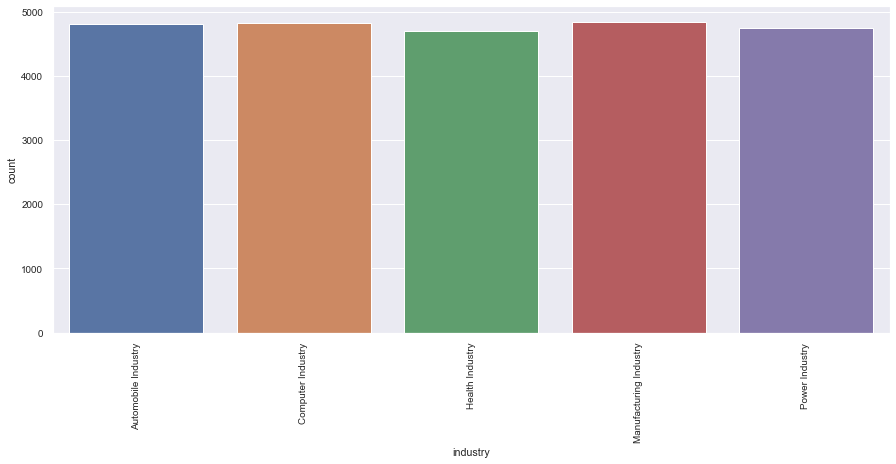

In [101]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
x = db_train['industry']
ax = sns.countplot(x=x, data=db_train)

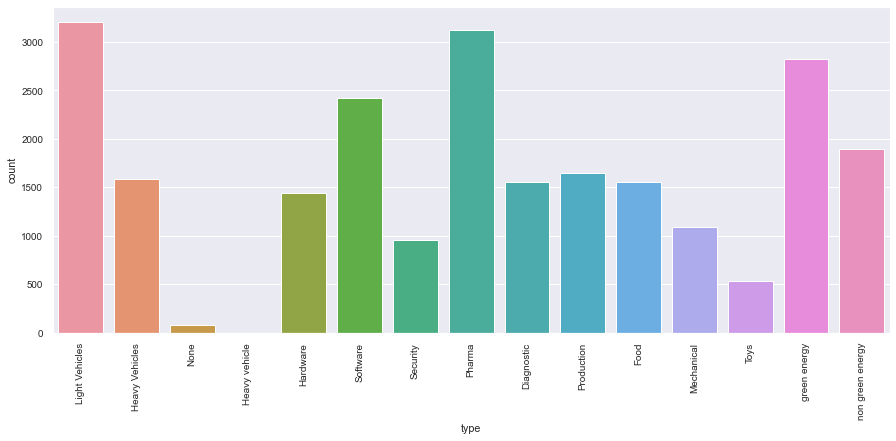

In [102]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
x = db_train['type']
ax = sns.countplot(x=x, data=db_train)

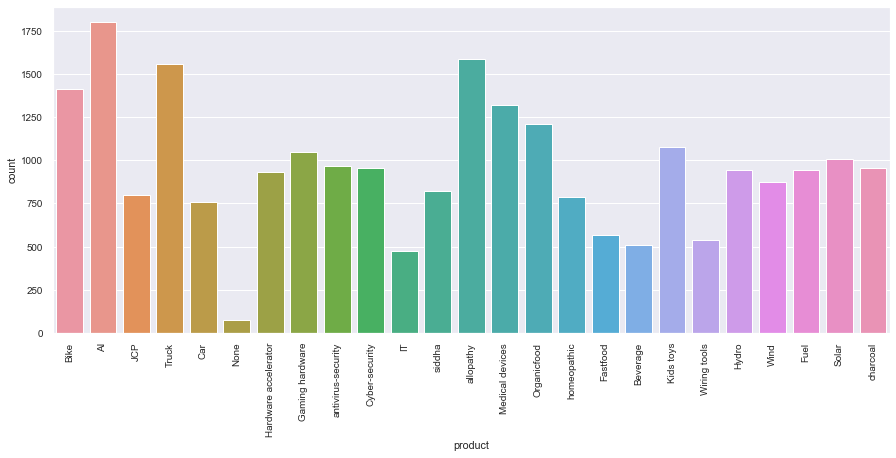

In [103]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
x = db_train['product']
ax = sns.countplot(x=x, data=db_train)

In [104]:
# Industry is well balanced while there are some imbalances in type and product
# For now, we are not taking any precaution for this such as adjusting evaluation metric etc. as most of the data seems balanced
# If there were a big imbalance, we could use the stratify parameter in train_test_split function

In [105]:
# Convert y-values to numbers and create a dictionary
ys = ["industry", "type", "product"]
y_map = {}
for y in ys:
    m = dict(db_train.drop_duplicates(y).reset_index()[y])
    reverse_m = {m[i]: i for i in m}
    db_train[y] = db_train[y].map(reverse_m)
    y_map[y] = m

# Save this as we will need the dictionary after inference
with open('processed_files/map.json', 'w') as f:
    json.dump(y_map, f)

In [106]:
# Take a look at mapped values
for i in y_map:
    print(i,":", ", ".join([y_map[i][j] for j in y_map[i]]))
    print("---")

industry : Automobile Industry, Computer Industry, Health Industry, Manufacturing Industry, Power Industry
---
type : Light Vehicles, Heavy Vehicles, None, Heavy vehicle, Hardware, Software, Security, Pharma, Diagnostic, Production, Food, Mechanical, Toys, green energy, non green energy
---
product : Bike, AI, JCP, Truck, Car, None, Hardware accelerator, Gaming hardware, antivirus-security, Cyber-security, IT, siddha, allopathy, Medical devices, Organicfood, homeopathic, Fastfood, Beverage, Kids toys, Wiring tools, Hydro, Wind, Fuel, Solar, charcoal
---


In [107]:
# Convert relevant X columns to OHE
db_train = pd.get_dummies(db_train, columns=ohe_cols)

## 2.4 Natural Language Processing

In [111]:
### NOTE: This cell takes considerable amount of time (~1 hour) due to tokenization & vectorization

# comp_back and prod_info

# remove duplicate indices
db_train = db_train.reset_index(drop=True)

# If we tokenize each column separately, it will bloat the future space.
# hence, we combine them before tokenization

db_train["info"] = np.NaN
db_train.loc[(db_train["comp_back"].notna()) & (db_train["prod_info"].notna()), "info"] = db_train["comp_back"] + " " + db_train["prod_info"]
db_train.loc[(db_train["comp_back"].notna()) & (db_train["prod_info"].isna()), "info"] = db_train["comp_back"]
db_train.loc[(db_train["comp_back"].isna()) & (db_train["prod_info"].notna()), "info"] = db_train["prod_info"]

# if you are running this script for the first time, you will need to download below corpus
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text) if type(text) == str else text

    # Lowercase and lemmatise
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens] if type(tokens) == list else tokens

    # Remove stopwords
    keywords = [lemma for lemma in lemmas if lemma not in stopwords.words('english')] if type(lemmas) == list else lemmas
    return keywords


vectorizer = TfidfVectorizer(analyzer=preprocess_text)
db_token = vectorizer.fit_transform(db_train['info'])
db_token = pd.DataFrame.sparse.from_spmatrix(db_token)
col_map = {v: k for k, v in vectorizer.vocabulary_.items()}
for col in db_token.columns:
    db_token.rename(columns={col: "t_" + col_map[col]}, inplace=True)

db_train = pd.concat([db_train, db_token], axis=1)
db_train.head()

,id,sym,ceo,comp_back,prod_info,no_of_emp,rev,net_val,share_price,industry,...,t_肉干,t_董天工,t_西山登紀子,t_覇権主義の歴史的巨悪の党の終焉を歓迎する,t_送陸鴻漸棲霞寺采茶,t_遠遠上層崖,t_采茶非采菉,t_青茶,t_𐀁𐀨𐀺,t_𐀁𐁉𐀺
0,PROJ0x5377,NaN,Pamela Terrano,The LCV concept was created as a compact truc...,5 million in 2019).36 mph (605.he just envisio...,0.0,15.226766,2284.014910,325.20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PROJ0x24dc,NaN,NaN,Data movement is typically from one place in m...,nan,0.0,-999.000000,-11230.811693,75.35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PROJ0x78e,NaN,NaN,1% share in Daimler AG.Dongfeng Motor and Niss...,"They surged forward in the 2014 elections, rec...",0.0,24.279113,7283.733783,653.65,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PROJ0x403b,NaN,NaN,"Software patents, like other types of patents,...",Referring to statistical significance does not...,17373.0,1.402778,35.069456,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PROJ0x8700,NaN,Elizabeth Finch,Data transmission has three aspects: transmiss...,Collaborative filtering by offering movies tha...,0.0,3.515203,703.040647,61.40,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
db_train.shape

(23909, 25940)

In [279]:
# Note: We could have tried "char" vectorization instead of "word" vectorization
# We can also try more advanced NLP models such as transformers

## 3. Modeling

## 3.1 Logistic Regression

F1 score for industry is 0.8855469468836924
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       982
           1       0.87      0.89      0.88       935
           2       0.87      0.90      0.88       921
           3       0.80      0.78      0.79       971
           4       1.00      1.00      1.00       973

    accuracy                           0.89      4782
   macro avg       0.89      0.89      0.89      4782
weighted avg       0.89      0.89      0.89      4782



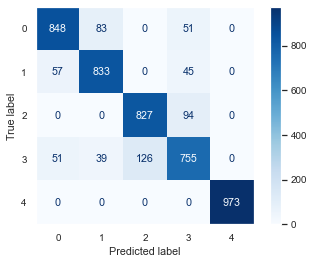

-----
F1 score for type is 0.7180858951645587
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       640
           1       0.73      0.71      0.72       340
           2       0.00      0.00      0.00        14
           4       0.45      0.50      0.47       281
           5       0.60      0.54      0.57       485
           6       0.49      0.56      0.52       167
           7       0.79      0.77      0.78       634
           8       0.52      0.61      0.56       282
           9       0.58      0.52      0.54       341
          10       0.80      0.81      0.80       294
          11       0.74      0.72      0.73       208
          12       0.56      0.58      0.57       124
          13       1.00      1.00      1.00       582
          14       1.00      1.00      1.00       390

    accuracy                           0.72      4782
   macro avg       0.64      0.64      0.64      4782
weighted avg       0.72      0.72 

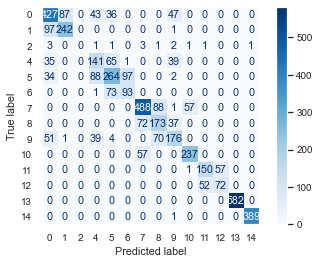

-----
F1 score for product is 0.9859541429550668
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       269
           1       0.99      1.00      0.99       336
           2       0.99      0.99      0.99       163
           3       1.00      0.99      1.00       333
           4       0.99      1.00      1.00       154
           5       1.00      0.27      0.42        15
           6       0.97      0.99      0.98       197
           7       1.00      0.97      0.98       218
           8       0.88      0.96      0.92       190
           9       0.94      0.87      0.91       177
          10       0.99      0.98      0.98        86
          11       0.99      0.99      0.99       176
          12       1.00      1.00      1.00       309
          13       1.00      1.00      1.00       271
          14       1.00      1.00      1.00       244
          15       0.99      0.99      0.99       151
          16       1.00      1.0

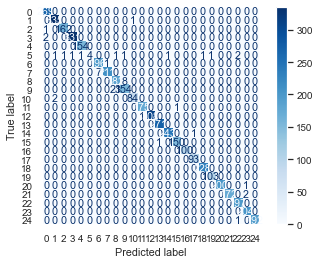

-----


In [113]:
# Drop unnecessary columns
db_log_model = db_train.drop(["id", "sym", "ceo", "comp_back", "prod_info","info"], axis=1)

# Move y columns to last
y_cols = ["industry", "type", "product"]
X_cols = [i for i in list(db_log_model.columns) if i not in y_cols]

# To keep the f1 score and model per y
f1s_log = {}
models_log = {}

for i in y_cols:
    # Create X and y
    X = db_log_model[X_cols]
    y = db_log_model[i].values.reshape(-1, 1)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize X
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models_log[i] = LogisticRegression(multi_class="multinomial", max_iter=100)

    models_log[i].fit(X_train, y_train.ravel())

    y_pred = models_log[i].predict_proba(X_test)
    y_pred = np.array(y_pred.argmax(1))
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    f1s_log[i] = f1

    print(f"F1 score for {i} is {f1}")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(models_log[i], X_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()
    print("-----")

In [ ]:
# We should have done hyperparameter optimization here but skipping it due to time constraint.
# Accuracy from this model will be used as baseline anyway

In [115]:
f1s_log

{'industry': 0.8855469468836924,
 'type': 0.7180858951645587,
 'product': 0.9859541429550668}

In [116]:
print(f'Accuracy score = {0.5 * f1s_log["industry"] + 0.3 * f1s_log["type"] + 0.2 * f1s_log["product"] }')

Accuracy score = 0.8553900705822272


## 3.2.1 Plain-vanilla XGBoost

[0]	validation_0-merror:0.14178
[1]	validation_0-merror:0.12777
[2]	validation_0-merror:0.12066
[3]	validation_0-merror:0.11460
[4]	validation_0-merror:0.10916
[5]	validation_0-merror:0.10644
[6]	validation_0-merror:0.10393
[7]	validation_0-merror:0.09828
[8]	validation_0-merror:0.09661
[9]	validation_0-merror:0.09410
[10]	validation_0-merror:0.09306
[11]	validation_0-merror:0.09055
[12]	validation_0-merror:0.08908
[13]	validation_0-merror:0.08846
[14]	validation_0-merror:0.08553
[15]	validation_0-merror:0.08302
[16]	validation_0-merror:0.08302
[17]	validation_0-merror:0.08135
[18]	validation_0-merror:0.07946
[19]	validation_0-merror:0.07842
[20]	validation_0-merror:0.07758
[21]	validation_0-merror:0.07800
[22]	validation_0-merror:0.07591
[23]	validation_0-merror:0.07570
[24]	validation_0-merror:0.07591
[25]	validation_0-merror:0.07361
[26]	validation_0-merror:0.07382
[27]	validation_0-merror:0.07319
[28]	validation_0-merror:0.07277
[29]	validation_0-merror:0.07319
[30]	validation_0-me

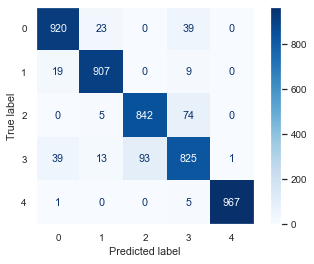

-----
[0]	validation_0-merror:0.29904
[1]	validation_0-merror:0.26893
[2]	validation_0-merror:0.25993
[3]	validation_0-merror:0.25240
[4]	validation_0-merror:0.24467
[5]	validation_0-merror:0.24258
[6]	validation_0-merror:0.24550
[7]	validation_0-merror:0.23881
[8]	validation_0-merror:0.23756
[9]	validation_0-merror:0.23860
[10]	validation_0-merror:0.23986
[11]	validation_0-merror:0.23589
[12]	validation_0-merror:0.23317
[13]	validation_0-merror:0.23233
[14]	validation_0-merror:0.22710
[15]	validation_0-merror:0.22982
[16]	validation_0-merror:0.22982
[17]	validation_0-merror:0.23003
[18]	validation_0-merror:0.23024
[19]	validation_0-merror:0.22940
[20]	validation_0-merror:0.22626
[21]	validation_0-merror:0.22752
[22]	validation_0-merror:0.22731
[23]	validation_0-merror:0.22396
[24]	validation_0-merror:0.22459
[25]	validation_0-merror:0.22417
[26]	validation_0-merror:0.22313
[27]	validation_0-merror:0.22355
[28]	validation_0-merror:0.22355
[29]	validation_0-merror:0.22417
[30]	validatio

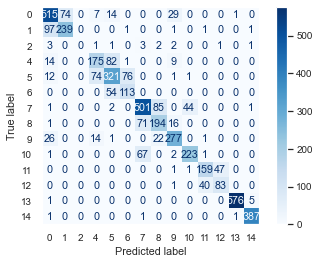

-----
[0]	validation_0-merror:0.12024
[1]	validation_0-merror:0.09076
[2]	validation_0-merror:0.08135
[3]	validation_0-merror:0.07654
[4]	validation_0-merror:0.07465
[5]	validation_0-merror:0.07194
[6]	validation_0-merror:0.06964
[7]	validation_0-merror:0.06754
[8]	validation_0-merror:0.06587
[9]	validation_0-merror:0.06378
[10]	validation_0-merror:0.06190
[11]	validation_0-merror:0.06085
[12]	validation_0-merror:0.05939
[13]	validation_0-merror:0.05918
[14]	validation_0-merror:0.05897
[15]	validation_0-merror:0.05793
[16]	validation_0-merror:0.05604
[17]	validation_0-merror:0.05604
[18]	validation_0-merror:0.05458
[19]	validation_0-merror:0.05332
[20]	validation_0-merror:0.05374
[21]	validation_0-merror:0.05291
[22]	validation_0-merror:0.05186
[23]	validation_0-merror:0.05165
[24]	validation_0-merror:0.05123
[25]	validation_0-merror:0.04998
[26]	validation_0-merror:0.04935
[27]	validation_0-merror:0.04768
[28]	validation_0-merror:0.04726
[29]	validation_0-merror:0.04747
[30]	validatio

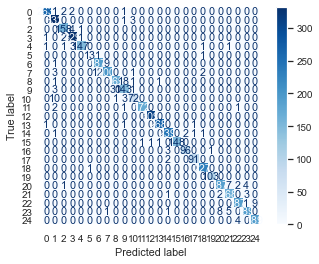

-----


In [117]:
# Drop unnecessary columns
db_xg_model = db_train.drop(["id", "sym", "ceo", "comp_back", "prod_info","info"], axis=1)

# Move y columns to last
# Below column also stores # classes per target variable
y_cols = {"industry": db_xg_model["industry"].nunique(), 
          "type":db_xg_model["type"].nunique(), 
          "product":db_xg_model["product"].nunique()}

X_cols = [i for i in list(db_xg_model.columns) if i not in y_cols]

# To keep the f1 score and model per y
f1s_xg = {}
models_xg = {}

# Lets save the models for future inference
os.makedirs("processed_files/xgb_models", exist_ok=True)

for i in y_cols:
    # Create X and y
    X = db_xg_model[X_cols]
    y = db_xg_model[i].values.reshape(-1, 1)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize X
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    models_xg[i] = xgboost.XGBClassifier(objective="multi:softmax", seed=42, num_class=y_cols[i])
    models_xg[i].fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric="merror", eval_set=[(X_test, y_test)])
    
    models_xg[i].save_model(f'processed_files/xgb_models/{i}.json')

    y_pred = models_xg[i].predict_proba(X_test)
    y_pred = np.array(y_pred.argmax(1))
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    f1s_xg[i] = f1

    print(f"F1 score for {i} is {f1}")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(models_xg[i], X_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()
    print("-----")

In [280]:
# Skipping Hyperparameter Optimization due to time constraint

# # Models can be read later as below
# bst = xgboost.XGBClassifier()  # init model
# bst.load_model('industry.json')  # load data

In [119]:
f1s_xg

{'industry': 0.9327554675677147,
 'type': 0.7860835100566449,
 'product': 0.9588778539100854}

In [120]:
print(f'Accuracy score = {0.5 * f1s_xg["industry"] + 0.3 * f1s_xg["type"] + 0.2 * f1s_xg["product"] }')

Accuracy score = 0.8939783575828679


## 3.2.2 XGBoost with updated feature space

In [172]:
# In this iteration, we feed y1 (industry) predictions into y2 (type) and y1, y2 predictions into y3 (product)
# as these variables are correlated
# In particular, accuracy is low in "type" and we'd like to improve it

In [203]:
# Drop unnecessary columns
db_xg_model_updated = db_train.drop(["id", "sym", "ceo", "comp_back", "prod_info","info"], axis=1)

In [204]:
## Prepare data

# Move y columns to last
# Below column also stores # classes per target variable
y_cols = {"industry": db_xg_model_updated["industry"].nunique(), 
          "type":db_xg_model_updated["type"].nunique(), 
          "product":db_xg_model_updated["product"].nunique()}

X_cols = [i for i in list(db_xg_model_updated.columns) if i not in y_cols]

# To keep the f1 score and model per y
f1s_xg_updated = {}
models_xg_updated = {}

# X and y
X = db_xg_model_updated[X_cols]
y= db_xg_model_updated[[i for i in y_cols]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_industry = y_train[:, 0].reshape(-1, 1)
y_train_type = y_train[:, 1].reshape(-1, 1)
y_train_product = y_train[:, 2].reshape(-1, 1)

y_test_industry = y_test[:, 0].reshape(-1, 1)
y_test_type = y_test[:, 1].reshape(-1, 1)
y_test_product = y_test[:, 2].reshape(-1, 1)

[0]	validation_0-mlogloss:1.13839
[1]	validation_0-mlogloss:0.90095
[2]	validation_0-mlogloss:0.74466
[3]	validation_0-mlogloss:0.63234
[4]	validation_0-mlogloss:0.55010
[5]	validation_0-mlogloss:0.48772
[6]	validation_0-mlogloss:0.43851
[7]	validation_0-mlogloss:0.39797
[8]	validation_0-mlogloss:0.36525
[9]	validation_0-mlogloss:0.33961
[10]	validation_0-mlogloss:0.31839
[11]	validation_0-mlogloss:0.30030
[12]	validation_0-mlogloss:0.28605
[13]	validation_0-mlogloss:0.27179
[14]	validation_0-mlogloss:0.26114
[15]	validation_0-mlogloss:0.25158
[16]	validation_0-mlogloss:0.24310
[17]	validation_0-mlogloss:0.23544
[18]	validation_0-mlogloss:0.22801
[19]	validation_0-mlogloss:0.22164
[20]	validation_0-mlogloss:0.21581
[21]	validation_0-mlogloss:0.21141
[22]	validation_0-mlogloss:0.20628
[23]	validation_0-mlogloss:0.20259
[24]	validation_0-mlogloss:0.19937
[25]	validation_0-mlogloss:0.19589
[26]	validation_0-mlogloss:0.19313
[27]	validation_0-mlogloss:0.19054
[28]	validation_0-mlogloss:0.1

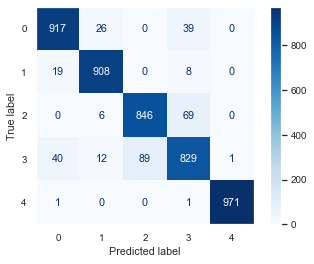

-----
(19127, 25931)
(19127, 25936)
(4782, 25931)
(4782, 25936)
[0]	validation_0-mlogloss:1.45711
[1]	validation_0-mlogloss:1.19718
[2]	validation_0-mlogloss:1.03510
[3]	validation_0-mlogloss:0.92855
[4]	validation_0-mlogloss:0.85508
[5]	validation_0-mlogloss:0.80179
[6]	validation_0-mlogloss:0.76416
[7]	validation_0-mlogloss:0.73923
[8]	validation_0-mlogloss:0.72214
[9]	validation_0-mlogloss:0.71136
[10]	validation_0-mlogloss:0.70514
[11]	validation_0-mlogloss:0.70298
[12]	validation_0-mlogloss:0.70186
[13]	validation_0-mlogloss:0.70222
[14]	validation_0-mlogloss:0.70361
[15]	validation_0-mlogloss:0.70817
[16]	validation_0-mlogloss:0.71076
[17]	validation_0-mlogloss:0.71388
[18]	validation_0-mlogloss:0.71798
[19]	validation_0-mlogloss:0.72340
[20]	validation_0-mlogloss:0.72919
[21]	validation_0-mlogloss:0.73398
[22]	validation_0-mlogloss:0.73773
F1 score for type is 0.7787008481694083
              precision    recall  f1-score   support

           0       0.75      0.80      0.77   

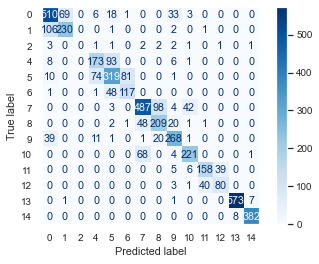

-----
(19127, 25936)
(19127, 25951)
(4782, 25936)
(4782, 25951)
[0]	validation_0-mlogloss:0.91647
[1]	validation_0-mlogloss:0.73129
[2]	validation_0-mlogloss:0.60633
[3]	validation_0-mlogloss:0.51399


KeyboardInterrupt: 

In [205]:
## 1. Industry

models_xg_updated["industry"] = xgboost.XGBClassifier(objective="multi:softprob", seed=42, num_class=y_cols[i])
models_xg_updated["industry"].fit(X_train, y_train_industry, verbose=True, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test_industry)])

# Inference - Train
y_pred_industry_train = models_xg_updated["industry"].predict_proba(X_train)
y_pred_industry_train = np.array(y_pred_industry_train.argmax(1))

# Inference - Test
y_pred_industry_test = models_xg_updated["industry"].predict_proba(X_test)
y_pred_industry_test = np.array(y_pred_industry_test.argmax(1))

f1 = f1_score(y_test_industry, y_pred_industry_test, average='weighted')

f1s_xg_updated["industry"] = f1

print(f"F1 score for industry is {f1}")
print(classification_report(y_test_industry, y_pred_industry_test))
plot_confusion_matrix(models_xg_updated["industry"], X_test, y_test_industry, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()
print("-----")


## 2. Type

## Merge X_train and with y_pred_industry_train
print(X_train.shape)
a = np.zeros((y_pred_industry_train.size, y_pred_industry_train.max()+1))
a[np.arange(y_pred_industry_train.size),y_pred_industry_train] = 1
X_train =  np.hstack((X_train, a))
print(X_train.shape)

## Merge X_test and with y_pred_industry_test
print(X_test.shape)
a = np.zeros((y_pred_industry_test.size, y_pred_industry_test.max()+1))
a[np.arange(y_pred_industry_test.size),y_pred_industry_test] = 1
X_test =  np.hstack((X_test, a))
print(X_test.shape)

models_xg_updated["type"] = xgboost.XGBClassifier(objective="multi:softprob", seed=42, num_class=y_cols[i])
models_xg_updated["type"].fit(X_train, y_train_type, verbose=True, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test_type)])

# Inference - Train
y_pred_type_train = models_xg_updated["type"].predict_proba(X_train)
y_pred_type_train = np.array(y_pred_type_train.argmax(1))

# Inference - Test
y_pred_type_test = models_xg_updated["type"].predict_proba(X_test)
y_pred_type_test = np.array(y_pred_type_test.argmax(1))


f1 = f1_score(y_test_type, y_pred_type_test, average='weighted')

f1s_xg_updated["type"] = f1

print(f"F1 score for type is {f1}")
print(classification_report(y_test_type, y_pred_type_test))
plot_confusion_matrix(models_xg_updated["type"], X_test, y_test_type, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()
print("-----")


## 3. Product

## Merge X_train and with y_pred_type_train
print(X_train.shape)
a = np.zeros((y_pred_type_train.size, y_pred_type_train.max()+1))
a[np.arange(y_pred_type_train.size),y_pred_type_train] = 1
X_train =  np.hstack((X_train, a))
print(X_train.shape)

## Merge X_test and with y_pred_type_test
print(X_test.shape)
a = np.zeros((y_pred_type_test.size, y_pred_type_test.max()+1))
a[np.arange(y_pred_type_test.size),y_pred_type_test] = 1
X_test =  np.hstack((X_test, a))
print(X_test.shape)

models_xg_updated["product"] = xgboost.XGBClassifier(objective="multi:softprob", seed=42, num_class=y_cols[i])
models_xg_updated["product"].fit(X_train, y_train_product, verbose=True, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test_product)])

# Inference - Train
y_pred_product_train = models_xg_updated["product"].predict_proba(X_train)
y_pred_product_train = np.array(y_pred_product_train.argmax(1))

# Inference - Test
y_pred_product_test = models_xg_updated["product"].predict_proba(X_test)
y_pred_product_test = np.array(y_pred_product_test.argmax(1))


f1 = f1_score(y_test_product, y_pred_product_test, average='weighted')

f1s_xg_updated["product"] = f1

print(f"F1 score for product is {f1}")
print(classification_report(y_test_product, y_pred_product_test))
plot_confusion_matrix(models_xg_updated["product"], X_test, y_test_product, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()
print("-----")

In [281]:
# I have stopped above model as it wasn't giving significantly better results compared to plain-vanilla XGBoost

## 3.3.1 Deep Learning - 3 forward pass for 3 outputs

In [123]:
# sklearn and XGBoost is not flexible in terms of how we can shape the outputs and model structure
# In fully-fledged DL libraries such as PyTorch, Ternsorflow, Keras, it is easy to customize cost function, output shape etc.
# An example of this is a project we did for a client in Japan
# We did not have any actual values (labels) for our prediction. There were only indirect labels such as, 
# sum of predictions should be equal to value A
# ratio of predictions should be equal to B and so on.
# We have used PyTorch for solving that problem via using indirect objectives

# This problem also requires some handling to model structure/ outputs
# "Type" is completely dependent on "Industry". Hence, we should feed our Industry predictions into our "Type" feature space
# "Product" is more or less dependent "Type". Same as above, we will be feeding higher hieararchy output into predicting this
# We can also adjust cost function so that, it takes into consideration the relative importance of each y variable
# (industry: 0.5, type:0.3, product:0.2)

db_dl_model = db_train.drop(["id", "sym", "ceo", "comp_back", "prod_info", "info"], axis=1)

# Move y columns to last
y_cols = ["industry", "type", "product"]
X_cols = [i for i in list(db_dl_model.columns) if i not in y_cols]

# Create X and y
X = db_dl_model[X_cols]
y = db_dl_model[y_cols]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize X
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert dataframe to np array
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert np array to torch tensor
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()


# Define model
class classifier(nn.Module):
    def __init__(self, no_of_features, y1_dim, y2_dim, y3_dim):
        # Hidden layer dimensions
        hidden1 = 256
        hidden2 = 128
        hidden3 = 64
        super(classifier, self).__init__()
        
        # Pipeline for "industry" predictions
        self.classifier1 = nn.Sequential(
            nn.Linear(no_of_features, hidden1),
            nn.ReLU(),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden3, y1_dim)
        )

        # Pipeline for "type" predictions
        self.classifier2 = nn.Sequential(
            nn.Linear(no_of_features + y1_dim, hidden1),
            nn.ReLU(),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden3, y2_dim)
        )

        # Pipeline for "product" predictions
        self.classifier3 = nn.Sequential(
            nn.Linear(no_of_features + y1_dim + y2_dim, hidden1),  # 3961 + 5 + 13
            nn.ReLU(),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden3, y3_dim)
        )

    def forward(self, x1):
        
        # This is where the magic happens
        y1 = self.classifier1(x1)
        
        # We are feeding our "industry" predictions (y1) into our "type" predictions' features (x2)
        x2 = torch.cat((x1, y1), 1)
        y2 = self.classifier2(x2)
        
        # We are feeding our "industry" and type" predictions (y1, y2) into our "product" predictions' features (x3)
        x3 = torch.cat((x2, y2), 1)
        y3 = self.classifier3(x3)
        
        # return predictions for 3 ys
        return [y1, y2, y3]

# Training pipeline
# Here we calculate cost and do gradient descent based on that
# We push 80% of data thru training
def train(model, optimizer, criterion, inputs, labels):
    model.train()
    optimizer.zero_grad()

    y1_labels = labels[:, 0]
    y2_labels = labels[:, 1]
    y3_labels = labels[:, 2]

    [y1, y2, y3] = model(inputs)

    y1_loss = criterion(y1, y1_labels)
    y2_loss = criterion(y2, y2_labels)
    y3_loss = criterion(y3, y3_labels)
    
    # Below combination of weights are found to give a better result compared to 0.5, 0.3, 0.2
    train_loss = 1 * y1_loss + 0.5 * y2_loss + 0.25 * y3_loss

    train_loss.backward()
    optimizer.step()
    return train_loss.item()

# Test pipeline
# Here we calculate and return accuracy metric
# We push 20% of data thru test
def test(model, inputs, labels):
    model.eval()
    with torch.no_grad(): 

        y1_labels = labels[:, 0]
        y2_labels = labels[:, 1]
        y3_labels = labels[:, 2]

        [y1, y2, y3] = model(inputs)

        # industry
        y_pred = torch.log_softmax(y1, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_1 = f1_score(y1_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')

        # type
        y_pred = torch.log_softmax(y2, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_2 = f1_score(y2_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')

        # product
        y_pred = torch.log_softmax(y3, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_3 = f1_score(y3_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')
        return [f1_1, f1_2, f1_3]


# Model Parameters
epochs = 100
learning_rate = 0.01
no_of_features = len(X.columns)
no_of_classes_1 = db_dl_model["industry"].nunique()
no_of_classes_2 = db_dl_model["type"].nunique()
no_of_classes_3 = db_dl_model["product"].nunique()

print(no_of_features, no_of_classes_1, no_of_classes_2, no_of_classes_3)

# More parameters...
model = classifier(no_of_features, no_of_classes_1, no_of_classes_2, no_of_classes_3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

os.makedirs("processed_files/nn_models", exist_ok=True)

f1s_dl = []

for epoch in range(1, epochs+1):
    loss = train(model, optimizer, criterion, X_train, y_train)
    accuracy = test(model, X_test, y_test)
    accuracy.append(0.5 * accuracy[0] + 0.3 * accuracy[1] + 0.2 * accuracy[2])
    f1s_dl.append([epoch] + accuracy)
    print(epoch, accuracy, loss)
    # Save model parameters for test inference
    path = f"processed_files/nn_models/epoch_{epoch}_dl_model.pth"
    torch.save(model.state_dict(), path)

25931 5 15 25
1 [0.39991786992433814, 0.10524482819400922, 0.07864891621415636, 0.2472621666632031] 3.7793917655944824
2 [0.8644367822476011, 0.21099885132322713, 0.21239244668839097, 0.5379965358584469] 3.6805732250213623
3 [0.8600810817586548, 0.19728022240097867, 0.22715624862339442, 0.5346558573242999] 3.282790184020996
4 [0.8651428832197967, 0.2771967527016751, 0.3114250025691834, 0.5780154679342375] 2.5214807987213135
5 [0.8226637791261082, 0.429298235498648, 0.46809178052325495, 0.6337397163172994] 1.7844674587249756
6 [0.7900736279261847, 0.5926662047905777, 0.5882523914906843, 0.6904871536984026] 1.7046161890029907
7 [0.8652708396633074, 0.6140447634039324, 0.60824790205695, 0.7384984292642234] 1.787723183631897
8 [0.8637369120479512, 0.5960822388398098, 0.7761006355725608, 0.7659132547904307] 1.2772542238235474
9 [0.8681755716536204, 0.6683628923805026, 0.8152084564162408, 0.7976383448242091] 1.0840219259262085
10 [0.8692161047093775, 0.6725951342154088, 0.8957742406743251, 0

81 [0.8743134310717601, 0.7046198002605962, 0.9808769938900096, 0.8447180543920608] 0.003300938755273819
82 [0.8745104525653282, 0.7069213739442228, 0.981106837314101, 0.845553005928751] 0.003289002925157547
83 [0.8753334148802451, 0.7076983608250902, 0.9805052941478039, 0.8460772745172104] 0.002595645608380437
84 [0.8753334148802451, 0.7063872638991989, 0.9813527381433907, 0.8458534342385603] 0.0025490284897387028
85 [0.8755419204879182, 0.7051841610189958, 0.981354479000275, 0.8455971043497128] 0.002446466125547886
86 [0.875745169872273, 0.7059159131729805, 0.9821510385141242, 0.8460775665908555] 0.0024592839181423187
87 [0.8753326928180739, 0.707283671603287, 0.981790723164806, 0.8462095925229842] 0.001960146240890026
88 [0.8751121075447633, 0.7086082193572366, 0.9819688449405539, 0.8465322885676634] 0.002101886086165905
89 [0.8755122483559207, 0.7085458014313138, 0.9825148607616196, 0.8468228367596784] 0.0022042265627533197
90 [0.8754911965300491, 0.7086272076122259, 0.982505876261

In [143]:
## Get the best result
acc_dl = pd.DataFrame(f1s_dl, columns = ["epoch", "acc1", "acc2", "acc3", "acc_total"])
print(acc_dl.sort_values("acc_total", ascending=False).head(1))

best_epoch = acc_dl.sort_values("acc_total", ascending=False).iloc[0,0]
best_epoch

    epoch      acc1      acc2      acc3  acc_total
42     43  0.876541  0.710184  0.982606   0.847847


43

In [284]:
print(f'Accuracy score = {acc_dl[acc_dl["epoch"] == best_epoch]["acc_total"].values[0] }')

Accuracy score = 0.8478467574921829


## 3.3.2 Deep Learning - Combined pass for 3 outputs

In [266]:
## In this model, we estimate 1 output variable of 1D which will be contenation of y1, y2, y3
# We want model to minimize cross entropy loss hollistically using 1 neural network holistically

# Prepare data
db_dl_model = db_train.drop(["id", "sym", "ceo", "comp_back", "prod_info", "info"], axis=1)

# Move y columns to last
y_cols = ["industry", "type", "product"]
X_cols = [i for i in list(db_dl_model.columns) if i not in y_cols]

# Create X and y
X = db_dl_model[X_cols]
y = db_dl_model[y_cols]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize X
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert dataframe to np array
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert np array to torch tensor
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [273]:
# Define model
class combined_classifier(nn.Module):
    def __init__(self, no_of_features, y1_dim, y2_dim, y3_dim):
        # Hidden layer dimensions
        hidden1 = 512
        hidden2 = 256
        hidden3 = 128
        hidden4 = 64
        hidden5 = 32

        super(combined_classifier, self).__init__()
        
        # Pipeline for "industry" predictions
        self.classifier = nn.Sequential(
            nn.Linear(no_of_features, hidden1),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(hidden3, hidden4),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            
            nn.Linear(hidden4, hidden5),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            
            nn.Linear(hidden5, y1_dim+y2_dim+y3_dim)
        )

    def forward(self, x):
        
        y = self.classifier(x)
        return y

In [274]:
# Training pipeline
# Here we calculate cost and do gradient descent based on that
# We push 80% of data thru training
def combined_train(model, optimizer, criterion, inputs, labels):
    model.train()
    optimizer.zero_grad()

    y1_labels = labels[:, 0]
    y2_labels = labels[:, 1]
    y3_labels = labels[:, 2]

    y = model(inputs)
    
    ## divide outputs into 3 sections
    y1_outputs = y[:, 0:no_of_classes_1]
    y2_outputs = y[:, no_of_classes_1:no_of_classes_1 + no_of_classes_2 ]
    y3_outputs = y[:, no_of_classes_1 + no_of_classes_2: ]


    y1_loss = criterion(y1_outputs, y1_labels)
    y2_loss = criterion(y2_outputs, y2_labels)
    y3_loss = criterion(y3_outputs, y3_labels)
    
    # Below combination of weights are found to give a better result compared to 0.5, 0.3, 0.2
    train_loss = 0.5 * y1_loss + 0.3 * y2_loss + 0.2 * y3_loss

    train_loss.backward()
    optimizer.step()
    return train_loss.item()

In [275]:
# Test pipeline
# Here we calculate and return accuracy metric
# We push 20% of data thru test
def combined_test(model, inputs, labels):
    model.eval()
    with torch.no_grad(): 

        y1_labels = labels[:, 0]
        y2_labels = labels[:, 1]
        y3_labels = labels[:, 2]

        y = model(inputs)

        ## divide outputs into 3 sections
        y1_outputs = y[:, :no_of_classes_1]
        y2_outputs = y[:, no_of_classes_1:no_of_classes_1 + no_of_classes_2 ]
        y3_outputs = y[:, no_of_classes_1 + no_of_classes_2: ]

        # industry
        y_pred = torch.log_softmax(y1_outputs, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_1 = f1_score(y1_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')

        # type
        y_pred = torch.log_softmax(y2_outputs, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_2 = f1_score(y2_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')

        # product
        y_pred = torch.log_softmax(y3_outputs, dim=1)
        _, y_pred = torch.max(y_pred, dim=1)
        f1_3 = f1_score(y3_labels.detach().numpy(), y_pred.detach().numpy(), average='weighted')
        return [f1_1, f1_2, f1_3]

In [276]:
# Model Parameters
epochs = 100
learning_rate = 0.005
no_of_features = len(X.columns)
no_of_classes_1 = db_dl_model["industry"].nunique()
no_of_classes_2 = db_dl_model["type"].nunique()
no_of_classes_3 = db_dl_model["product"].nunique()

print(no_of_features, no_of_classes_1, no_of_classes_2, no_of_classes_3)

# More parameters...
combined_model = combined_classifier(no_of_features, no_of_classes_1, no_of_classes_2, no_of_classes_3)
optimizer = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

25931 5 15 25


In [271]:
# Set storage
os.makedirs("processed_files/nn_models", exist_ok=True)

f1s_dl_combined = []

In [277]:
for epoch in range(1, epochs+1):
    loss = combined_train(combined_model, optimizer, criterion, X_train, y_train)
    accuracy = combined_test(combined_model, X_test, y_test)
    accuracy.append(0.5 * accuracy[0] + 0.3 * accuracy[1] + 0.2 * accuracy[2])
    f1s_dl_combined.append([epoch] + accuracy)
    print(epoch, accuracy, loss)
    # Save model parameters for test inference
    path = f"processed_files/nn_models/epoch_{epoch}_dl_updated_model.pth"
    torch.save(combined_model.state_dict(), path)

1 [0.06997121695369897, 0.0023568715409937532, 0.0039752404851526564, 0.03648771803617814] 2.2633395195007324
2 [0.14241944448970797, 0.004556863455274336, 0.00496511302562409, 0.0735698038865611] 2.25736665725708
3 [0.34256630584989856, 0.13737686706720056, 0.026652594554790143, 0.2178267319560675] 2.2446093559265137
4 [0.4309399206616565, 0.20801650670320476, 0.03857626825719197, 0.28559016599322806] 2.2030954360961914
5 [0.4208008059283943, 0.24973111295684217, 0.03458645800981248, 0.29223702845321226] 2.1030259132385254
6 [0.6199543293931373, 0.1877113251884462, 0.06012040086118836, 0.3783146424253402] 1.967578411102295
7 [0.7358589344033417, 0.24848313396143148, 0.06796349074692573, 0.45606710553948543] 1.8261401653289795
8 [0.8606913336733482, 0.2718410589163294, 0.09183040362484679, 0.5302640652365422] 1.6808643341064453
9 [0.8661566937934843, 0.2956481883142531, 0.07934600099079145, 0.5376420035891764] 1.5296392440795898
10 [0.8671282369608796, 0.313064673330635, 0.064654090158

81 [0.8761962044678552, 0.713270723190622, 0.9649022214244489, 0.845059763476004] 0.045031704008579254
82 [0.8750453484949767, 0.7091709370709489, 0.9657796311847288, 0.8434298816057189] 0.04354066401720047
83 [0.874956998494078, 0.7111583869602677, 0.9651421538755317, 0.8438544461102256] 0.04180372133851051
84 [0.8750046000153683, 0.7122430823426485, 0.9649179060974489, 0.8441588059299685] 0.03886176645755768
85 [0.8743512840963985, 0.711294779566572, 0.9659337103546799, 0.8437508179891069] 0.038807742297649384
86 [0.8745321617634177, 0.712212252763395, 0.9661574552065771, 0.8441612477520428] 0.03915780037641525
87 [0.8738354046274074, 0.7116028090939396, 0.9665725967072586, 0.8437130643833373] 0.03596390038728714
88 [0.8733261241107301, 0.7102721910772569, 0.9661587314430323, 0.8429764656671487] 0.03700801730155945
89 [0.873167520602687, 0.7126748928930596, 0.9659302668836476, 0.843572281545991] 0.03720530495047569
90 [0.8721809283074011, 0.7115160901596828, 0.9663768712869958, 0.842

In [286]:
## Get the best result
acc_dl_combined = pd.DataFrame(f1s_dl_combined, columns = ["epoch", "acc1", "acc2", "acc3", "acc_total"])
print(acc_dl_combined.sort_values("acc_total", ascending=False).head(1))

best_epoch_combined = acc_dl_combined.sort_values("acc_total", ascending=False).iloc[0,0]
best_epoch_combined

    epoch      acc1     acc2      acc3  acc_total
77     68  0.878016  0.71331  0.961356   0.845272


68

In [287]:
print(f'Accuracy score = {acc_dl_combined[acc_dl_combined["epoch"] == best_epoch_combined]["acc_total"].values[0] }')

Accuracy score = 0.8452723741957133


## Comparison

We have conducted 3 modelling approaches in this notebook.
Below, we show accuracies for industry, type, product and at overall level (weighs: 0.5, 0.3, 0.2)

## 1) Logistic regression (Baseline)

Accuracy: [0.8855469468836924, 0.7180858951645587, 0.9859541429550668, 0.8553900705822272]

Advantages: Easy to design, run and analyze

Disadvantages: Simplistic, high accuracy can't be achieved compared to other advanced methods

Potential further work that:

1) Hyperparameter optimization

2) Try other classification approaches such as Linear/ Quadratic Discriminant Analysis 

## 2) XGBoost

Accuracy: [0.9327554675677147, 0.7860835100566449, 0.9588778539100854, 0.8939783575828679]

Advantages: Highly accurate, Easy to design

Disadvantage: Many parameters to tune for, Prone to overfitting

Potential further work: 

1) Hyperparameter tuning

2) Feed "industry" predictions into "type" and "industry" and "type" predictions into "product" predictions as we know that there is a realtionship among these target variables (Please look at the matrix we have created in EDA for overlap between these variables)

3) Overfitting measures

3) Try other tree boosting methods such as CatBoost or LightBGM
 

## 3) Deep Learning (Multilayer Perceptron)

Accuracy: [0.8765406010155086, 0.7101841551607019, 0.98260605218109, 0.8478467574921829]

Advantages:Highly flexible (model structure and cost function can be customized as needed), Great at handling large volume of data

Disadvantages: Slow, Difficult to do feature importance analysis (Integrated Gradients can be used though)

Potential further work:

1) Update forward function so that relationship between y variables is strengthened

2) Hyperparameter optimization


## 4) Selection

Although we haven't hyperparameter tuned XGBoost nor focused on resolving overfitting, it seems like the best option among above 3 options thanks to its high accuracy in the test data. 

## 5) Comments

In this notebook, we have tested 3 modeling approaches in the order of increasing complexity and found that XGBoost gave the best accuracy.

In order to find the best model, we can try other models such as Random Forests.

One major limitation in this hackathon (as is the case with other hackathons) was the time limitation. NLP columns have contributed significantly to our accuracy, however, they slowed down the data processing and training as well, limiting our capability to test further models, do hyperparameter optimization, and prevent overfitting.

## Inference

## 1. Process test data

In [125]:
# make column names consistent and order them so that floats come after objects within X, and y comes after X
cols = {'ID': 'id',
        'Symbol': 'sym',
        'Start_date': 'st_date',
        'market_cap': 'mkt_cap',
        'Sector': 'sector',
        'Country': 'country',
        'CEO': 'ceo',
        'Company_background': 'comp_back',
        'product_info': 'prod_info',
        'No.of employee': 'no_of_emp',
        'Revenue (Cr)': 'rev',
        'Net-valuation (Cr)': 'net_val',
        'Share_price (RS)': 'share_price'
        }

db_test = db_test.rename(columns=cols)
db_test = db_test[[cols[i] for i in cols]]

# st_date
# Below may be required to correctly identify data format
locale.setlocale(locale.LC_TIME, "en_US") 

db_test.st_date = pd.to_datetime(db_test.st_date, format='%B,%Y')
db_test['st_date_y'] = pd.DatetimeIndex(db_test['st_date']).year
db_test['st_date_m'] = pd.DatetimeIndex(db_test['st_date']).month

# as st_date_y and st_date_m will be treated as floats, convert NaNs to 0
db_test[["st_date_y", "st_date_m"]] = db_test[["st_date_y", "st_date_m"]].fillna(0)
db_test = db_test.drop("st_date", axis=1)

# floats: no_of_emp, rev, net_val, share_price
db_test[["rev"]] = db_test[["rev"]].apply(pd.to_numeric, errors='coerce', axis=1)

# As these data are floats, convert NaNs to 0s
db_test[["no_of_emp", "rev", "net_val", "share_price"]] = db_test[["no_of_emp", "rev", "net_val", "share_price"]].fillna(0)

# No of employees and share price can't be lower than 0
db_test[["no_of_emp", "share_price"]] = db_test[["no_of_emp", "share_price"]].clip(lower=0)

# OHE
db_test = pd.get_dummies(db_test, columns=ohe_cols)

# comp_back and prod_info
# remove duplicate indices
db_test = db_test.reset_index(drop=True)

# If we tokenize each column separately, it will bloat the future space.
# hence, we combine them before tokenization
db_test["info"] = np.NaN
db_test.loc[(db_test["comp_back"].notna()) & (db_test["prod_info"].notna()), "info"] = db_test["comp_back"] + " " + db_test["prod_info"]
db_test.loc[(db_test["comp_back"].notna()) & (db_test["prod_info"].isna()), "info"] = db_test["comp_back"]
db_test.loc[(db_test["comp_back"].isna()) & (db_test["prod_info"].notna()), "info"] = db_test["prod_info"]

# if you are running this script for the first time, you will need to download below corpus
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text) if type(text) == str else text

    # Lowercase and lemmatise
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens] if type(tokens) == list else tokens

    # Remove stopwords
    keywords = [lemma for lemma in lemmas if lemma not in stopwords.words('english')] if type(lemmas) == list else lemmas
    return keywords


vectorizer = TfidfVectorizer(analyzer=preprocess_text, max_features=500)
db_token_test = vectorizer.fit_transform(db_test['info'])
db_token_test = pd.DataFrame.sparse.from_spmatrix(db_token_test)
col_map = {v: k for k, v in vectorizer.vocabulary_.items()}
for col in db_token_test.columns:
    db_token_test.rename(columns={col: "t_" + col_map[col]}, inplace=True)

db_test = pd.concat([db_test, db_token_test], axis=1)
db_test.head()

,id,sym,ceo,comp_back,prod_info,no_of_emp,rev,net_val,share_price,st_date_y,...,t_米湯,t_肉夹馍,t_芽茶以火作者为次,t_西山登紀子,t_覇権主義の歴史的巨悪の党の終焉を歓迎する,t_送陸鴻漸棲霞寺采茶,t_遠遠上層崖,t_采茶非采菉,t_𐀁𐀨𐀺,t_𐀁𐁉𐀺
0,PROJ0x51fa,NaN,Vicenta Bronstein,The food processing industry is one of the lar...,ISBN 978-0-9758252-0-4. ISBN 978-0-12-374628-3...,0.0,0.683632,8507.104743,65.800000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PROJ0x3c88,NaN,Nelson Bodkin,Well-designed government policies that promote...,Wind energy penetration is the fraction of ene...,7964.0,0.000000,0.000000,1617.536129,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PROJ0x3e72,NaN,NaN,Information services Information services is ...,it is another good example of Artificial Intel...,0.0,2.519536,755.860918,755.400000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PROJ0x1129,NaN,NaN,Not available,The following setup is configured in the senso...,0.0,-999.000000,155.498484,94.700000,1979.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PROJ0x9029,NaN,NaN,"In 2007, there were about 806 million cars and...",New vehicles will be issued a virtual identifi...,6954.0,0.000000,34880.360760,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# Since train and test have different word corpus, when we tokenize the product_info and comp_back, they will have different # of columns
# Also columns will be ordered differently
# For inference, we need to have exact columns in exact same order with train
# Hence in the next section we will remove columns that are only in test and add the ones that are only in train

print(len(set(list(db_train.columns)).intersection(set(list(db_test.columns)))))
print(len(set(list(db_train.columns))))
print(len(set(list(db_test.columns))))

24336
25940
25020


## 2. Equalize columns of train and test due to NLP columns

In [127]:
db_test_ = db_test.copy()

# Drop NLP columns that were not included in the training dataframe

only_test_cols = [col for col in db_test.columns if col not in db_train.columns]
only_train_cols = [col for col in db_train.columns if col not in db_test.columns]

print(db_test.shape)

# Drop this amount of columns
print(len(only_test_cols))
db_test = db_test.drop(only_test_cols, axis=1)
print(db_test.shape)

# Create an empty train dataframe
db_empty_train =  db_train[0:0]
print(db_empty_train.shape)

# Fill values with test data
db_test = pd.concat([db_empty_train,db_test])

# Check that # columns match with train df
print(db_test.shape)

# Check that there are no additional columns created
print(db_train.shape[1], db_test.shape[1])
print([col for col in db_test.columns if col not in db_train.columns])
print([col for col in db_train.columns if col not in db_test.columns])

# Check how new columns look like
print(db_test[only_train_cols].head())

# Remove y values and fill NaNs with 0 as newly added words did not appear in test list
y_cols = ["industry", "type", "product"]
db_test = db_test.drop(y_cols, axis=1)
db_test = db_test.fillna(0)

print(db_test[[i for i in only_train_cols if i not in y_cols]].head())

# check that # columns are same in train and test datasets
print(db_test.shape[1] + 3 == db_train.shape[1] ) # due to 3 missing ys

(15890, 25020)
684
(15890, 24336)
(0, 25940)
(15890, 25940)
25940 25940
[]
[]
   industry  type  product  t_014  t_03151  t_0537  t_065  t_066x  t_070  \
0       NaN   NaN      NaN    NaN      NaN     NaN    NaN     NaN    NaN   
1       NaN   NaN      NaN    NaN      NaN     NaN    NaN     NaN    NaN   
2       NaN   NaN      NaN    NaN      NaN     NaN    NaN     NaN    NaN   
3       NaN   NaN      NaN    NaN      NaN     NaN    NaN     NaN    NaN   
4       NaN   NaN      NaN    NaN      NaN     NaN    NaN     NaN    NaN   

   t_078070  ...  t_ἄρκτος  t_工夫紅茶  t_武夷山志  t_渥堆  t_煮泉小品  t_田艺蘅  t_福鼎白茶  t_肉干  \
0       NaN  ...       NaN     NaN     NaN   NaN     NaN    NaN     NaN   NaN   
1       NaN  ...       NaN     NaN     NaN   NaN     NaN    NaN     NaN   NaN   
2       NaN  ...       NaN     NaN     NaN   NaN     NaN    NaN     NaN   NaN   
3       NaN  ...       NaN     NaN     NaN   NaN     NaN    NaN     NaN   NaN   
4       NaN  ...       NaN     NaN     NaN   NaN     NaN    

## 3. Predict

In [128]:
db_xg_infer = db_test.drop(["id", "sym", "ceo", "comp_back", "prod_info","info"], axis=1)

print(db_xg_infer.shape[1], db_xg_model.shape[1]) # 2nd should be 3 more than 1st

# Predictions to be made for:
y_cols = ["industry", "type", "product"]
preds = {}

for i in y_cols:
    
    # Create X
    X = db_xg_infer.copy()
    
    # Normalize X
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    
    y_pred = models_xg[i].predict_proba(X_norm)
    y_pred = np.array(y_pred.argmax(1))
    print(i, y_pred)
    preds[i] = y_pred

25931 25934
industry [2 4 1 ... 1 4 2]
type [ 7 13  4 ...  6 13  7]
product [14 21  1 ...  9 21 12]


In [129]:
# Check whether sizes match

for i in preds:
    print(i, len(preds[i]), db_test.shape[0])

industry 15890 15890
type 15890 15890
product 15890 15890


In [130]:
preds["industry"] = preds["industry"].reshape(len(preds["industry"]),1 )
preds["type"] = preds["type"].reshape(len(preds["type"]),1 )
preds["product"] = preds["product"].reshape(len(preds["type"]),1 )

In [131]:
pred_vals = np.concatenate((preds["industry"], preds["type"], preds["product"]), axis=1 )
pred_df = pd.DataFrame(pred_vals, columns=["industry", "type", "product"]) 
pred_df.describe()
pred_df

,industry,type,product
0,2,7,14
1,4,13,21
2,1,4,1
3,0,0,1
4,0,1,2
...,...,...,...
15885,1,5,6
15886,0,1,3
15887,1,6,9
15888,4,13,21


In [132]:
df_final = db_test["id"]

df_final = pd.concat([df_final, pred_df], axis=1).drop("index", axis=1, errors='ignore')
df_final

,id,industry,type,product
0,PROJ0x51fa,2,7,14
1,PROJ0x3c88,4,13,21
2,PROJ0x3e72,1,4,1
3,PROJ0x1129,0,0,1
4,PROJ0x9029,0,1,2
...,...,...,...,...
15885,PROJ0x27fb,1,5,6
15886,PROJ0x3261,0,1,3
15887,PROJ0x3aff,1,6,9
15888,PROJ0x1082,4,13,21


In [133]:
# Assign actual values
for i in y_cols:
    df_final[i] = df_final[i].map(y_map[i])

df_final = df_final.rename(columns={"id": "ID", "industry": "Industry", "type": "Type", "product": "Product"})

In [136]:
# check product info etc. just to make sure that predictions are correctly mapped back
pd.set_option('max_colwidth', 400)
df_final_check = df_final.copy()
db_test_check = db_test.rename(columns={"id": "ID"})
df_final_check = df_final_check.merge(db_test_check, on="ID", how="left")

In [139]:
df_final_check[['ID', 'Industry', 'Type', 'Product', "comp_back",  "prod_info"]]

,ID,Industry,Type,Product,comp_back,prod_info
0,PROJ0x51fa,Health Industry,Pharma,Organicfood,"The food processing industry is one of the largest industries in India and is all set to soar heights in the near future. Even, Government of India also knows the Future is too bright for Indian food Industries, as, food has also been one of the largest segments in India’s retail sector, which was valued at USD 490 billion in 2013. The Indian food retail market is expected to reach USD 894.98 ...","ISBN 978-0-9758252-0-4. ISBN 978-0-12-374628-3Images of fruit development from flowers at bioimages. Fresh fruits and vegetables should be carefully selected; at the store, they should not be damaged or bruised; and precut pieces should be refrigerated or surrounded by ice. University of California Press. It is derived from the ovary wall of the flower, (apricot, cherry, olive, peach, plum, ma..."
1,PROJ0x3c88,Power Industry,green energy,Wind,"Well-designed government policies that promote energy system transformation can lower greenhouse gas emissions and improve air quality simultaneously, and in many cases can also increase energy security. In 1956, the silicon controlled rectifier (SCR) was introduced, increasing the range of power electronic applications.The scale and pace of policy reforms that have been initiated as of 2020 a...","Wind energy penetration is the fraction of energy produced by wind compared with the total generation.Wind power is capital intensive but has no fuel costs.For example, the wind industry in the US in early 2014 was able to produce more power at lower cost by using taller wind turbines with longer blades, capturing the faster winds at higher elevations. Pelton wheels and de Laval turbines use ..."
2,PROJ0x3e72,Computer Industry,Hardware,AI,"Information services Information services is a term somewhat loosely applied to a variety of IT-related services offered by commercial companies, as well as data brokers. data-at-rest"". On a PC one will usually have the ability to change the platform software.",it is another good example of Artificial Intelligence software as it is an intelligent disruption management platform. It combines the best software engineering methods with artificial intelligence and machine learning paradigms and techniques to both models and solves complex problems. Masdima’s artificial intelligence software has been designed to help businesses minimize the impact of disru...
3,PROJ0x1129,Automobile Industry,Light Vehicles,AI,Not available,"The following setup is configured in the sensors to detect the presence of passengers:\nThen each pixel's location can be represented as a vector indicating the coordinates of that pixel in the image, [x, y], where x and y are the row and column of a pixel in the image matrix.Increased computing power has also led to the growing popularity of computationally intensive methods based on resampli..."
4,PROJ0x9029,Automobile Industry,Heavy Vehicles,JCP,"In 2007, there were about 806 million cars and light trucks on the road, consuming over 980 billion litres (980,000,000 m3) of gasoline and diesel fuel yearly. It would have had two super heavy variants: one able to lift 50-60 tons, and another able to lift 130-150 tons.The American Saturn MLV family of rockets was proposed in 1965 by NASA as successors to the Saturn V rocket.","New vehicles will be issued a virtual identification consisting of a combination of alphanumeric symbols, which will make it easier for the LTO to release the permanent license plates once they are available. The extensive use of armored bulldozers during the Second Intifada drew controversy and criticism from human-rights organizations, while military experts saw it as a key factor in reducin..."
...,...,...,...,...,...,...
15885,PROJ0x27fb,Computer Industry,Software,Hardware accelerator,"Some of the ethical issues associated with the use of information technology include:Breaches of copyright by those downloading files stored without 

In [289]:
# Results seem to make sense. Write them to output file
os.makedirs("processed_files", exist_ok=True)

df_final.to_csv("processed_files/Danyel_Koca_22227_prediction.csv", index=False)

## For conclusion (best model selection), please scroll up to Conclusion section